In [40]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

In [41]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']

training_path    = '../../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [42]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [43]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [44]:
FRAME_SIZE = 1024 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [45]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [46]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [47]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [48]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [49]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [50]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

In [51]:
def smooth_envelope(signal, sr, cutoff_frequency=10.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)

In [52]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [53]:
#3d
def plot_features3D(features:dict):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    ax = fig.add_subplot(111, projection='3d')
    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

    # configure labels
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [120]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [121]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(BER)
        feat = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        #frames = range(len(feat))
        #t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        #absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        #momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        #means = np.mean(feat)

        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

**BER**

- Con la media del BER

C:\Users\Juan\AppData\Local\Temp\ipykernel_7208\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


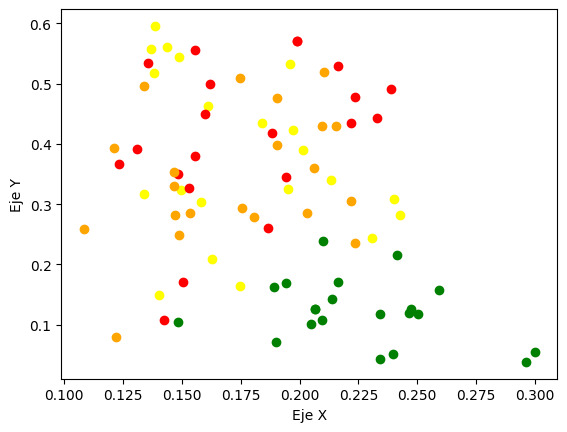

In [125]:
features = dict.fromkeys(fruit_types)
split_frequency = 600

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        spec = librosa.stft(signal, n_fft = 512, hop_length = 256)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(np.abs(BER))
        feat = np.mean(BER)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el RMS del BER

C:\Users\Juan\AppData\Local\Temp\ipykernel_7208\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


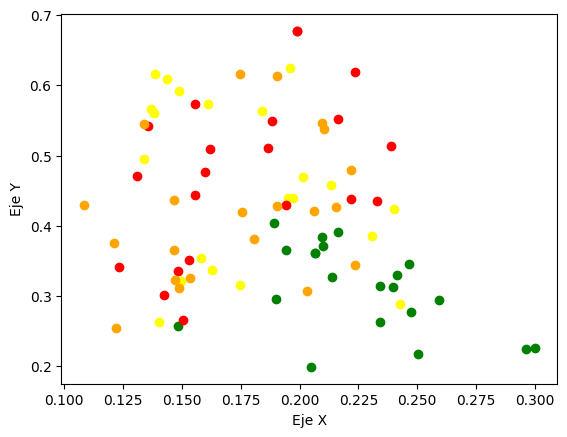

In [126]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(np.abs(BER))
        feat = np.sqrt(np.mean(BER**2))/np.max(BER)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el maximo del BER.

Se separan muchísimo las peras de lo demás. Con el split en 600 y un frame size de 512 anda separando a las peras de lo demas bastante bien.

C:\Users\Juan\AppData\Local\Temp\ipykernel_7208\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


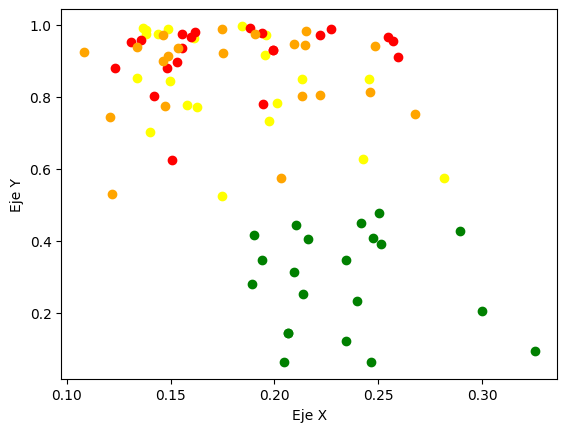

In [127]:
features = dict.fromkeys(fruit_types)
split_frequency = 600

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        spec = librosa.stft(signal, n_fft = 512, hop_length = 256)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        feat = np.max(np.abs(BER))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- con 512 de frame a un split de 1900 separa a las bananas del resto de las cosas.
- con 512 de frames a un split de alrededor de 5000 se estratifican las frutas quedando las manzanas en el fondo y las bananas arriba.
- con 512 de grame sa un split de alrededor de 8000 a 10000 la estratificación no se ve tanto y las manzanas quedan bien al fondo

C:\Users\Juan\AppData\Local\Temp\ipykernel_7208\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


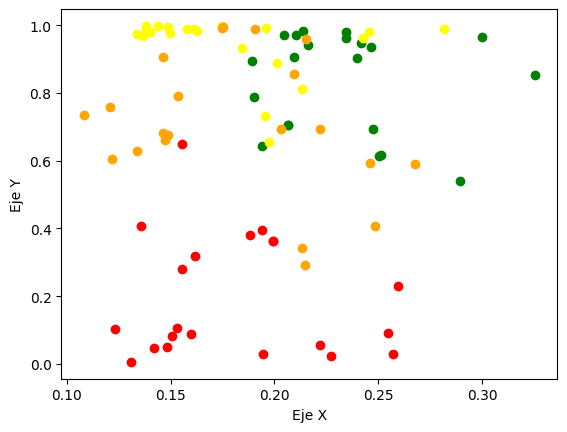

In [128]:
features = dict.fromkeys(fruit_types)
split_frequency = 9500

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        spec = librosa.stft(signal, n_fft = 512, hop_length = 256)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        feat = np.min(np.abs(BER))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la varianza del BER

In [ ]:
features = dict.fromkeys(fruit_types)
split_frequency = 3000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        spec = librosa.stft(signal, n_fft = 512, hop_length = 256)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(BER)
        feat = np.var(np.abs(BER))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la desviación estándar

- Con un frame de 512 con un split de alrededor de 8000 se separan las manzanas de lo demás quedando arriba del resto y además las bananas como que quedan al fondo.
- A frecuencias de split mas bajas, de alrededor de 1000 con el mismo fram_size se separan las peras de lo demás, quedando arriba del resto

C:\Users\Juan\AppData\Local\Temp\ipykernel_7208\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


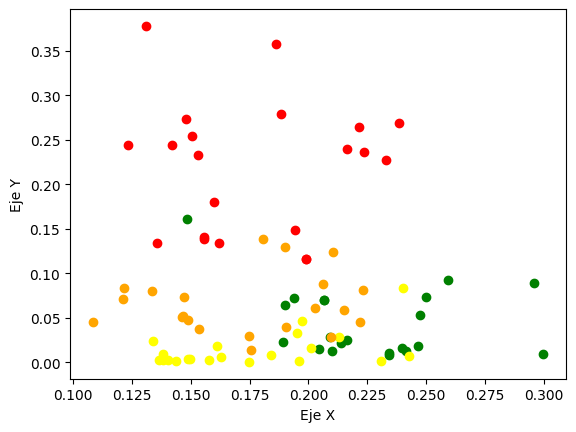

In [147]:
features = dict.fromkeys(fruit_types)
split_frequency = 8000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        spec = librosa.stft(signal, n_fft = 512, hop_length = 256)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(np.abs(BER))
        feat = np.std(BER)/np.mean(np.abs(BER))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el momento sin la suma

In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(np.abs(BER))
        frames = range(len(BER))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)

        feat = np.dot(BER, t)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el momento con suma
- Con un frame de 512 con un split de alrededor de 1800 se separan las peras de lo demás quedando abajo

C:\Users\Juan\AppData\Local\Temp\ipykernel_7208\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


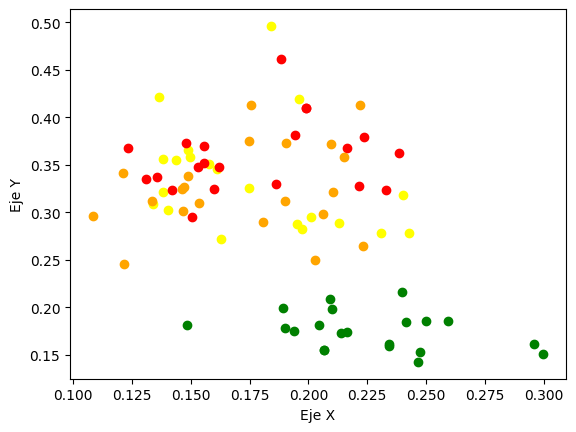

In [159]:
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(np.abs(signal))

        spec = librosa.stft(signal, n_fft = 512, hop_length = 256)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(np.abs(BER))
        frames = range(len(BER))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=256, n_fft = 512)

        feat = np.dot(np.abs(BER), t)/np.sum(np.abs(BER))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el momento del valor absoluto sin suma

In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(np.abs(BER))
        frames = range(len(BER))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)

        feat = np.dot(np.abs(BER), t)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el momentum del BER en abs y la suma

In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 3000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.max(np.abs(BER))
        frames = range(len(BER))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)

        feat = np.dot(np.abs(BER), t)/np.sum(np.abs(BER))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)